In [13]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
import cv2
import pandas as pd
from skimage.color import rgb2gray
from PIL import Image
from sklearn.cluster import KMeans

**DISPLAY RGB, GRAY, BINARY IMAGE**

In [2]:
img_path = '/Users/hassaanmuzammil/Desktop/GBMC/Color-coded-pattern.png'

In [3]:
def read_display(img_path):
    
    # read rgb image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # Convert to grayscale
    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Convert to binary
    img_bin = (img_gray > 50).astype('uint8')

    # display rgb, grayscale and binary image
    plt.figure(figsize=(10,20))
    plt.subplot(1,3,1)
    plt.imshow(img)
    plt.title('RGB Image')
    plt.subplot(1,3,2)
    plt.imshow(img_gray, cmap='gray')
    plt.title('Grayscale Image')
    plt.subplot(1,3,3)
    plt.imshow(img_bin, cmap='gray')
    plt.title('Binary Image')
    plt.show()
    
    return img, img_gray, img_bin

#read_display(img_path)

**HELPER FUNCTIONS**

In [35]:
def r_shift(s, i):
    if i == 0:
       return s
    return s[-i:] + s[0:len(s)-i]     

In [4]:
red = np.array([255,0,0])
blue = np.array([0,255,255])
green = np.array([0,255,0])
yellow = np.array([255,255,0])
black = np.array([0,0,0])

colors = np.stack((red,yellow,green,blue,black))
color_dict = {0:'R',1:'Y',2:'G',3:'B',4:'Bl'}

def identify_color(rgb_val):
  c_list = []
  for i in colors:
    c_list.append(np.sum((i-rgb_val)**2))
    
  return color_dict[c_list.index(min(c_list))]

# ***PROCEDURE***

- GET ALL CIRCLE CENTROIDS AND COLORS >>> CONNECTED COMPONENTS
- FORMULATE RECTANGULAR GRID >>>  QUANTIZED X,Y CENTROIDS
- EXTRACT ALL COLORS >>> IDENTIFY COLORS ON INTERSECTING GRID POINTS
- GENERATE ALL POSSIBLE 3X3 PATTERNS >>> BASED ON COLOR ALIGNMENT WRT GRID

**GET CIRCLE CENTROIDS AND COLORS**

In [5]:
def get_centroids(img, img_bin):
    num_labels, labels = cv2.connectedComponents(img_bin)
    centroids = {}
        
    for i in range(num_labels):
    
        # get x,y center coordinate of label
        x = np.int(np.mean(np.where(labels==i)[0]))
        y = np.int(np.mean(np.where(labels==i)[1]))
        
        # identify color of x,y coordinate
        c = identify_color(img[x,y])
        
        # add pair {center:color} to dictionary circles 
        if c != 'Bl':
            centroids[(x,y)] = c
        
    return centroids

**QUANTIZE CLUSTER CENTROIDS TO FORM RECTANGULAR GRID**

In [6]:
def get_quantized_coordinates(centroids, xnum=10, ynum=10):
    xvals, yvals = ([], [])
    for x,y in centroids.keys():
        xvals.append(x)
        yvals.append(y)
    
    X = np.array(xvals).reshape(-1,1)
    kmeans = KMeans(n_clusters=xnum, random_state=1).fit(X)
    centers_x = kmeans.cluster_centers_
    
    X = np.array(yvals).reshape(-1,1)
    kmeans = KMeans(n_clusters=ynum,random_state=1).fit(X)
    centers_y = kmeans.cluster_centers_
    
    return sorted(centers_x), sorted(centers_y)

**EXTRACT COLORS FROM IMAGE BASED ON GRID**

In [7]:
def get_general_pattern(img, centers_x, centers_y):
    final_list = []
    for i in range(len(centers_x)):
        lst = []
        for j in range(len(centers_y)):
            x = int(centers_x[i])
            y = int(centers_y[j])
            c = identify_color(img[x,y])
            lst.append(c)
        final_list.append(lst)
    
    return final_list

**GENERATE ALL POSSIBLE 3x3 PATTERNS**

In [8]:
color_dict2 = {'R':0,'Y':1,'G':2,'B':3,'Bl':4}

def generate_codes(pattern, centers_x, centers_y):
    code_dict = {}
    pattern = np.array(pattern)
    for i in range(1,len(centers_x)-1):
        for j in range(1,len(centers_y)-1):
            x2,x3,x4 = pattern[i-1:i+2,j+1]
            x1,x0,x5 = pattern[i-1:i+2,j]
            x8,x7,x6 = pattern[i-1:i+2,j-1]
            
            code_str = x0+x1+x2+x3+x4+x5+x6+x7+x8
            code_str = ''.join([str(color_dict2[i]) for i in code_str])

            code_dict[(int(centers_x[i]),int(centers_y[j]))] = code_str
    return code_dict

**GENERAL FUNCTION**

In [11]:
def get_color_pattern(img_path, num_x, num_y):
    # read, display and store images
    img, img_gray, img_bin = read_display(img_path)
    # apply connected components, get centroids of labels and identify their colors
    centroids = get_centroids(img, img_bin)
    # quantized x,y value of centroids
    centers_x,centers_y = get_quantized_coordinates(centroids, num_x, num_y)
    # get arrangement of all colors i.e. general pattern
    pattern = get_general_pattern(img, centers_x, centers_y)
    #generate 3x3 codes
    code_dict = generate_codes(pattern, centers_x, centers_y)
    
    return centroids, pattern, code_dict

**TESTING ON A FEW IMAGES**

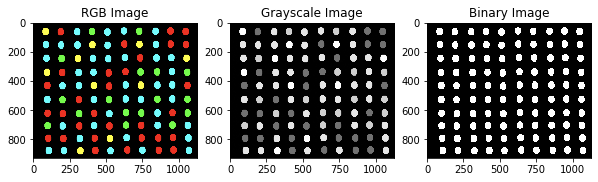

In [97]:
#centroids >> c, pattern >> p, code_dict >> cd
c1,p1,cd1 = get_color_pattern(img_path, 10, 10)

In [98]:
#c1,p1,cd1

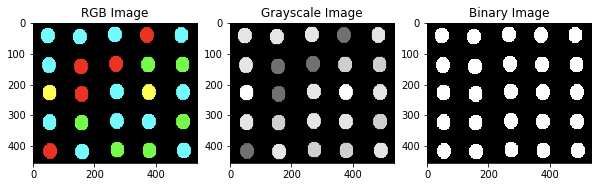

In [99]:
img_path_2 = '/Users/hassaanmuzammil/Desktop/GBMC/5x5.png'
c2, p2, cd2 = get_color_pattern(img_path_2, 5, 5)

In [100]:
#c2,p2,cd2

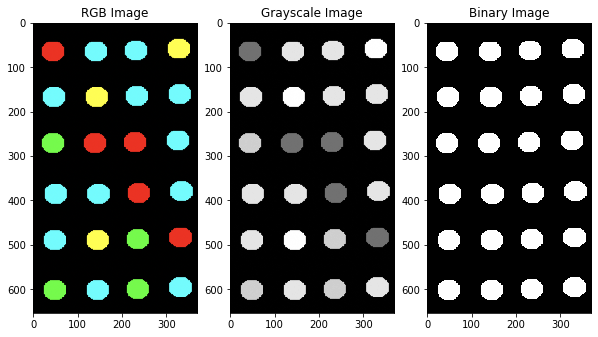

In [101]:
img_path_3 = '/Users/hassaanmuzammil/Desktop/GBMC/(5x5)90.png'
c3, p3, cd3 = get_color_pattern(img_path_3, 6, 4)

In [102]:
#c3,p3,cd3

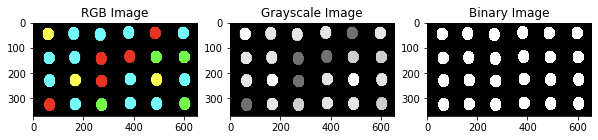

In [111]:
img_path_4 = '/Users/hassaanmuzammil/Desktop/GBMC/(5x5)2.png'
c4, p4, cd4 = get_color_pattern(img_path_4, 4, 6)

**GET SAME PATTERNS ACROSS TWO IMAGES**

In [103]:
def get_key(val, my_dict):
    for key, value in my_dict.items():
         if val == value:
             return key

def get_rotated_codes(code_dict):
    cd = code_dict.copy()
    for key,value in cd.items():
        p2 = []
        for j in range(8):
            p2.append(value[0]+r_shift(value[1:],j))
            cd[key] = p2
    
    return cd

In [115]:
def same_points(code_dict1, code_dict2):
    same_patterns = []
    cd1 = get_rotated_codes(code_dict1)
    cd2 = get_rotated_codes(code_dict2)
    
    for key,val in cd1.items():
        cd1[key] = sorted(val)
    for key,val in cd2.items():
        cd2[key] = sorted(val)  
        
    same_patterns = [lst for lst in cd1.values() if lst in cd2.values()]
    print('No. of same 3x3 patterns detected: ',len(same_patterns))
    
    lst1,lst2 = ([],[])
    for val in same_patterns:
        p1 = get_key(val, cd1)
        p2 = get_key(val, cd2)
        lst1.append(p1)
        lst2.append(p2)
        print('Pattern: ',val[0])
        print('Found at ',p1,' in image 1')
        print('Found at ',p2,' in image 2')
   
    return lst1,lst2

**TEST CASES**

In [146]:
#same_points(cd1,cd3)

In [148]:
#same_points(cd1,cd2)

In [147]:
#same_points(cd2,cd3)

In [156]:
lst1,lst2 = same_points(cd1,cd4)

No. of same 3x3 patterns detected:  8
Pattern:  300133133
Found at  (341, 414)  in image 1
Found at  (135, 165)  in image 2
Pattern:  001333303
Found at  (341, 518)  in image 1
Found at  (135, 269)  in image 2
Pattern:  000330213
Found at  (341, 632)  in image 1
Found at  (135, 383)  in image 2
Pattern:  203032313
Found at  (341, 736)  in image 1
Found at  (135, 487)  in image 2
Pattern:  100230333
Found at  (431, 414)  in image 1
Found at  (225, 165)  in image 2
Pattern:  000332313
Found at  (431, 518)  in image 1
Found at  (225, 269)  in image 2
Pattern:  300021332
Found at  (431, 632)  in image 1
Found at  (225, 383)  in image 2
Pattern:  102232333
Found at  (431, 736)  in image 1
Found at  (225, 487)  in image 2


In [157]:
from matplotlib.patches import ConnectionPatch

def draw_connections(path1,path2,lst1,lst2):

    img1 = Image.open(path1)
    img2 = Image.open(path2)

    fig = plt.figure(figsize=(20,20))

    ax1 = fig.add_subplot(1,2,1)
    ax1.imshow(img1)

    ax2 = fig.add_subplot(1,2,2)
    ax2.imshow(img2)


    # Draw an arrow between the same point in data coordinates,
    # but in different axes.

    for i in range(len(lst1)):
        xy = [lst1[i][1],lst1[i][0]]
        x2y2 = [lst2[i][1],lst2[i][0]]
        con = ConnectionPatch(xyA=xy, coordsA=ax1.transData,xyB=x2y2, coordsB=ax2.transData,arrowstyle="<->", shrinkB=5)
        con.set_color('w')
        con.set_linewidth(5)
        fig.add_artist(con)

    plt.show()

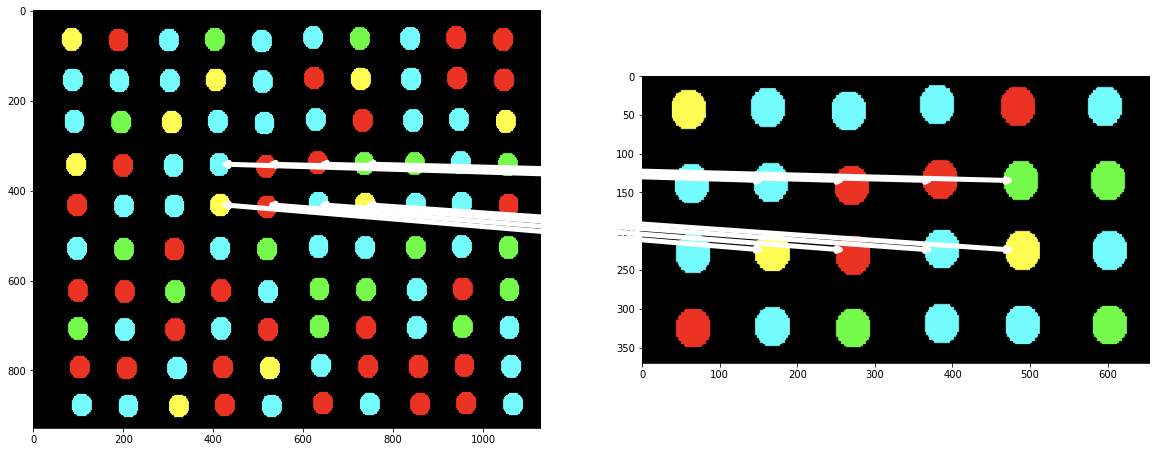

In [159]:
draw_connections(img_path,img_path_4,lst1,lst2)